-1.0
Upper OuterCoil: I= 0.000, V = 0.051123+1.292814j 
Lower OuterCoil: I= 0.000, V = 0.055612+1.437736j 
InnerCoil: I= 0.020, V = 0.45226523+4.21246720j 
-0.8
Upper OuterCoil: I= 0.000, V = 0.051579+1.307324j 
Lower OuterCoil: I= 0.000, V = 0.055173+1.423358j 
InnerCoil: I= 0.020, V = 0.45226773+4.21282446j 
-0.6
Upper OuterCoil: I= 0.000, V = 0.052035+1.321842j 
Lower OuterCoil: I= 0.000, V = 0.054731+1.408922j 
InnerCoil: I= 0.020, V = 0.45227056+4.21229124j 
-0.3999999999999999
Upper OuterCoil: I= 0.000, V = 0.052493+1.336358j 
Lower OuterCoil: I= 0.000, V = 0.054288+1.394402j 
InnerCoil: I= 0.020, V = 0.45226796+4.21087287j 
-0.19999999999999996
Upper OuterCoil: I= 0.000, V = 0.052943+1.350863j 
Lower OuterCoil: I= 0.000, V = 0.053845+1.379928j 
InnerCoil: I= 0.020, V = 0.45228081+4.21063714j 
0.0
Upper OuterCoil: I= 0.000, V = 0.053389+1.365448j 
Lower OuterCoil: I= 0.000, V = 0.053390+1.365443j 
InnerCoil: I= 0.020, V = 0.45227133+4.21351687j 
0.20000000000000018
Upper OuterCoi

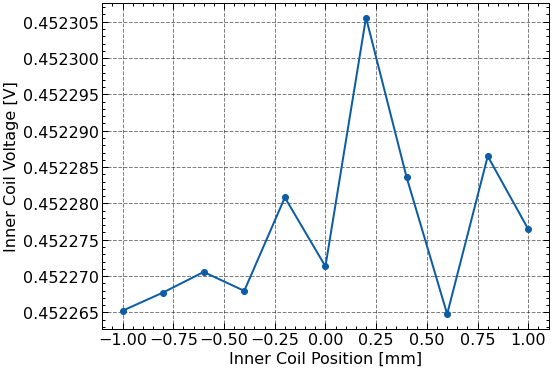

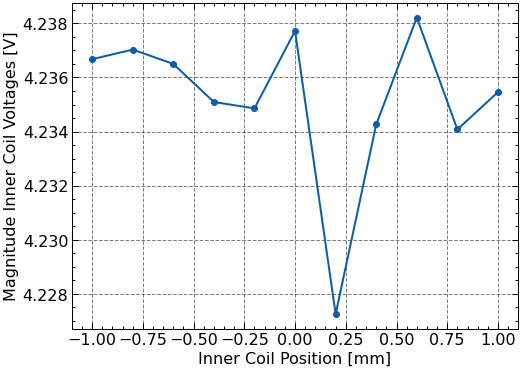

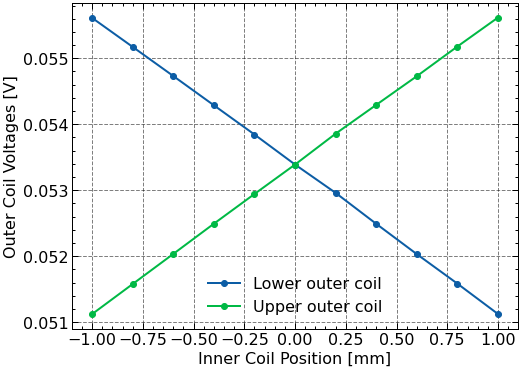

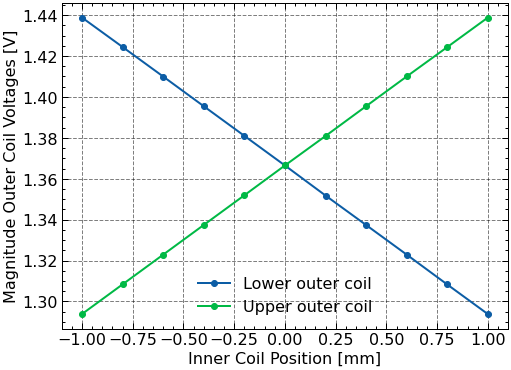

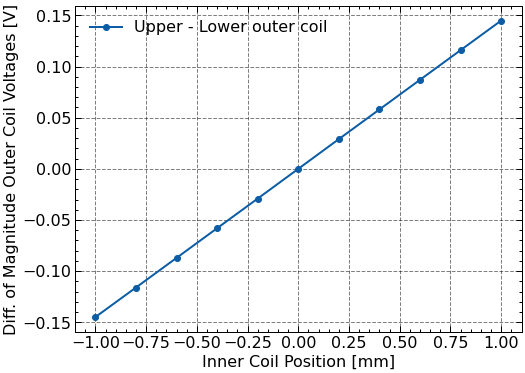

[1.46384252 1.46385093 1.46383683 1.46380169 1.46379273 1.46386753
 1.4635935  1.46377692 1.46388163 1.46377157 1.46380899]
[1.53213519 1.53205347 1.53196959 1.53188334 1.53179612 1.53171572
 1.53160871 1.5315366  1.53145443 1.5313568  1.53127146]
[1.53127329 1.53136324 1.53145137 1.53153617 1.5316243  1.53171602
 1.53178443 1.53187942 1.53197183 1.53204787 1.53213173]
Phase offset: -0.06829266687454894 -0.06832273541297762


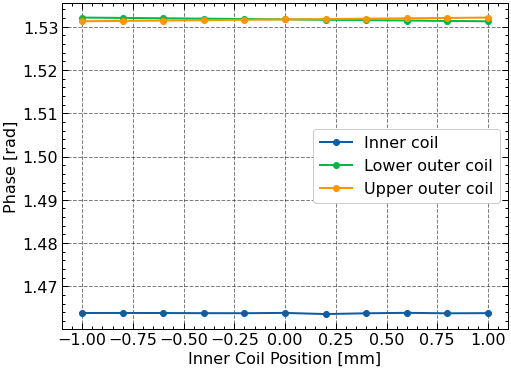

Fitted slope of the function: 36.2730619305803
[3.62730619e+01 2.56654902e-03]


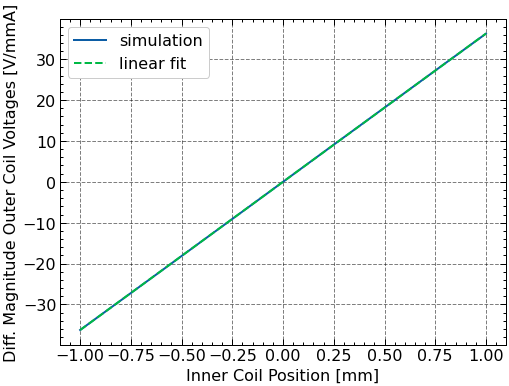

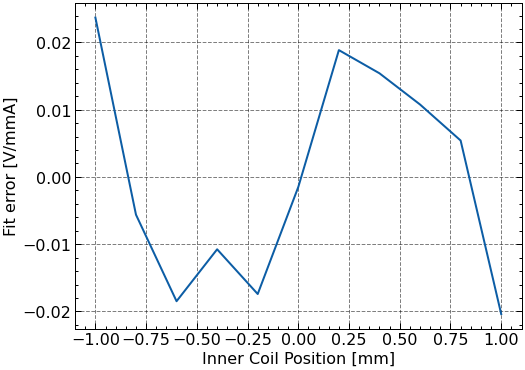

[-3.62704954e+01 -2.90158830e+01 -2.17612706e+01 -1.45066582e+01
 -7.25204584e+00  2.56654902e-03  7.25717894e+00  1.45117913e+01
  2.17664037e+01  2.90210161e+01  3.62756285e+01]
[-3.62468003e+01 -2.90214932e+01 -2.17797488e+01 -1.45174177e+01
 -7.26945407e+00  1.07497830e-03  7.27603398e+00  1.45272007e+01
  2.17771712e+01  2.90264279e+01  3.62552384e+01]


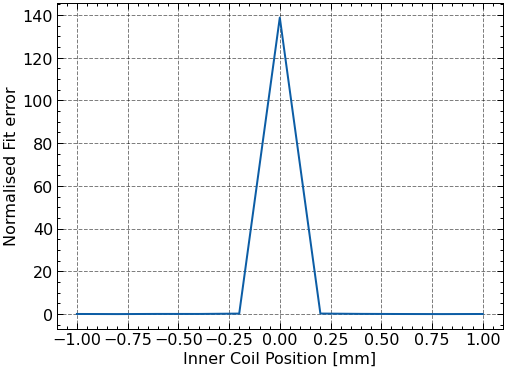

In [40]:

import femm
import numpy as np
import cmath
import scipy.optimize as opt
import matplotlib.pyplot as plt
import shutil
# The package must be initialized with the openfemm command.
femm.openfemm()

# We need to create a new Magnetostatics document to work on.
femm.newdocument(0)

outputfile = 'LVDT_10kHz_20mA_31AWG_10mm_6_7_7.out'
NSteps = 10
StepSize = 0.2
InnCoil_Offset = -1

class Sensortype():
    def __init__(self, InnCoilCurrent, Simfreq, OutCoilCurrent):
        self.InnCoilCurrent = InnCoilCurrent
        self.Simfreq = Simfreq
        self.OutCoilCurrent = OutCoilCurrent

    def para(self):
        return [self.InnCoilCurrent, self.Simfreq, self.OutCoilCurrent]

sensor = Sensortype(0.02, 10000, 0)

femm.mi_probdef(sensor.para()[1], 'millimeters', 'axi', 1.0e-10)

class Wiretype():
    def __init__(self, outcoil_material, inncoil_material):
        self.outcoil_material = outcoil_material
        self.inncoil_material = inncoil_material

    def prop31(self):
        return [0.2261, 0.0190, "31 AWG"]

    def prop32(self):
        return [0.2032, 0.0178, "32 AWG"]

    def mag_mat(self):
        mat = "N40"
        return mat

wire = Wiretype("31 AWG", "31 AWG")

class Geometry():
    def __init__(self, inn_ht, inn_rad, inn_layers, inn_dist, out_ht, out_rad, out_layers, out_dist, mag_len, mag_dia, ver_shi):

        self.inn_ht = inn_ht
        self.inn_rad = inn_rad
        self.inn_layers = inn_layers
        self.inn_dist = inn_dist
        self.out_ht = out_ht
        self.out_rad = out_rad
        self.out_layers = out_layers
        self.out_dist = out_dist
        self.mag_len = mag_len
        self.mag_dia = mag_dia
        self.ver_shi = ver_shi

    def inncoil(self):
        return [self.inn_ht, self.inn_rad, self.inn_layers, self.inn_dist]

    def outcoil(self):
        return [self.out_ht, self.out_rad, self.out_layers, self.out_dist]

    def mag(self):
        return [self.mag_len, self.mag_dia, self.ver_shi]

geo = Geometry(inn_ht = 25, inn_rad = 9, inn_layers = 6, inn_dist = 0, out_ht = 13.5, out_rad = 20, out_layers = 7, out_dist = 28.5, mag_len = 40, mag_dia = 10, ver_shi = 0)

class Position():
    def __init__(self):
        pass

    def inncoil(self):
        InnCoil_OutRadius = geo.inncoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.inncoil()[2])
        InnCoil_Lowend = (geo.inncoil()[3] - geo.inncoil()[0]) / 2
        InnCoil_Uppend = InnCoil_Lowend + geo.inncoil()[0]
        InnCoil_NrWind_p_Layer = (geo.inncoil()[0]) / (wire.prop31()[0] + wire.prop31()[1] * 2)
        InnCoil_NrWindings = InnCoil_NrWind_p_Layer * geo.inncoil()[2]
        InnCoil_Circuit = "InnCoil_Circuit"
        return [InnCoil_OutRadius, InnCoil_Lowend, InnCoil_Uppend, InnCoil_NrWind_p_Layer, InnCoil_NrWindings,
                InnCoil_Circuit]

    def upp_outcoil(self):
        UppOutCoil_OutRadius = geo.outcoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.outcoil()[2])
        UppOutCoil_LowEnd = (geo.outcoil()[3] - geo.outcoil()[0]) / 2
        UppOutCoil_UppEnd = UppOutCoil_LowEnd + geo.outcoil()[0]
        UppOutCoil_NrWind_p_Layer = (geo.outcoil()[0]) / (wire.prop31()[0] + wire.prop31()[1] * 2)
        UppOutCoil_NrWindings = UppOutCoil_NrWind_p_Layer * geo.outcoil()[2]
        UppOutCoil_Circuit = "UppOutCoil_Circuit"
        return [UppOutCoil_OutRadius, UppOutCoil_LowEnd, UppOutCoil_UppEnd, UppOutCoil_NrWind_p_Layer,
                UppOutCoil_NrWindings, UppOutCoil_Circuit]

    def low_outcoil(self):
        LowOutCoil_OutRadius = geo.outcoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.outcoil()[2])
        LowOutCoil_UppEnd = -1 * ((geo.outcoil()[3] - geo.outcoil()[0]) / 2)
        LowOutCoil_LowEnd = LowOutCoil_UppEnd - geo.outcoil()[0]
        LowOutCoil_NrWind_p_Layer = (LowOutCoil_UppEnd - LowOutCoil_LowEnd) / (
                    wire.prop31()[0] + wire.prop31()[1] * 2)
        LowOutCoil_NrWindings = LowOutCoil_NrWind_p_Layer * geo.outcoil()[2]
        LowOutCoil_Circuit = "LowOutCoil_Circuit"
        return [LowOutCoil_OutRadius, LowOutCoil_UppEnd, LowOutCoil_LowEnd, LowOutCoil_NrWind_p_Layer,
                LowOutCoil_NrWindings, LowOutCoil_Circuit]

    def magnet(self):
        Magnet_UppEnd = geo.mag()[0] / 2 + geo.mag()[2]
        Magnet_LowEnd = -geo.mag()[0] / 2 + geo.mag()[2]
        Magnet_Radius = geo.mag()[1] / 2
        return [Magnet_UppEnd, Magnet_LowEnd, Magnet_Radius]

position = Position()

class Length():
    def __init__(self):
        pass

    def inncoil(self):
        InnCoil_TotalWire = 0
        for i in range(0, geo.inncoil()[2]):
            # circ = 2*np.pi*InnCoil_InRadius+i*(InnCoil_WireDiam+InnCoil_WireInsul)
            circ = 2 * np.pi * (geo.inncoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            InnCoil_TotalWire += circ * position.inncoil()[3]
        print("Total length of wire (mm):", InnCoil_TotalWire)
        print("\n")
        return InnCoil_TotalWire

    def upp_outcoil(self):
        UppOutCoil_TotalWire = 0
        for i in range(0, geo.outcoil()[2]):
            # circ = 2*np.pi*(UppOutCoil_InRadius+i*(UppOutCoil_WireDiam+UppOutCoil_WireInsul))
            circ = 2 * np.pi * (geo.outcoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            UppOutCoil_TotalWire += circ * position.upp_outcoil()[3]
        print("Total length of wire (mm):", UppOutCoil_TotalWire)
        print("\n")
        return UppOutCoil_TotalWire

    def low_outcoil(self):
        LowOutCoil_TotalWire = 0
        for i in range(0, geo.outcoil()[2]):
            # circ = 2*np.pi*LowOutCoil_InRadius+i*(LowOutCoil_WireDiam+LowOutCoil_WireInsul)
            circ = 2 * np.pi * (geo.outcoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            LowOutCoil_TotalWire += circ * position.low_outcoil()[3]
        print("Total length of wire (mm):", LowOutCoil_TotalWire)
        print("\n")
        return LowOutCoil_TotalWire

length = Length()

# InnerCoil Structure
femm.mi_drawrectangle(geo.inncoil()[1], position.inncoil()[2], position.inncoil()[0], position.inncoil()[1])
femm.mi_addcircprop(position.inncoil()[5], sensor.para()[0], 1)

if wire.inncoil_material == "31 AWG":
    femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
if wire.inncoil_material == "32 AWG":
    femm.mi_getmaterial(wire.inncoil_material)

femm.mi_clearselected()
femm.mi_selectrectangle(geo.inncoil()[1], position.inncoil()[2], position.inncoil()[0], position.inncoil()[1], 4)
femm.mi_setgroup(1)
femm.mi_clearselected()
femm.mi_addblocklabel(geo.inncoil()[1] + wire.prop31()[1], position.inncoil()[1] + (geo.inncoil()[0] / 2))
femm.mi_selectlabel(geo.inncoil()[1] + wire.prop31()[1], position.inncoil()[1] + (geo.inncoil()[0] / 2))
femm.mi_setblockprop(wire.prop31()[2], 1, 0, position.inncoil()[5], 0, 1, position.inncoil()[4])
femm.mi_clearselected()

# UpperOutCoil Structure
femm.mi_drawrectangle(geo.outcoil()[1], position.upp_outcoil()[2], position.upp_outcoil()[0],
                      position.upp_outcoil()[1])
femm.mi_addcircprop(position.upp_outcoil()[5], sensor.para()[2], 1)

if wire.outcoil_material == "31 AWG":
    femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
if wire.outcoil_material == "32 AWG":
    femm.mi_getmaterial(wire.inncoil_material)

femm.mi_clearselected()
femm.mi_selectrectangle(geo.outcoil()[1], position.upp_outcoil()[2], position.upp_outcoil()[0],
                        position.upp_outcoil()[1], 4)
femm.mi_setgroup(3)
femm.mi_clearselected()
femm.mi_addblocklabel(geo.outcoil()[1] + wire.prop31()[1], position.upp_outcoil()[2] - (geo.outcoil()[0] * 0.5))
femm.mi_selectlabel(geo.outcoil()[1] + wire.prop31()[1], position.upp_outcoil()[2] - (geo.outcoil()[0] * 0.5))
femm.mi_setblockprop(wire.prop31()[2], 0, 0.1, position.upp_outcoil()[5], 0, 3, position.upp_outcoil()[4])
femm.mi_clearselected()

# LowerOutCoil Structure
femm.mi_drawrectangle(geo.outcoil()[1], position.low_outcoil()[1], position.low_outcoil()[0],
                      position.low_outcoil()[2])
femm.mi_addcircprop(position.low_outcoil()[5], -sensor.para()[2], 1)

if wire.outcoil_material == "31 AWG":
    femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
if wire.outcoil_material == "32 AWG":
    femm.mi_getmaterial(wire.inncoil_material)

femm.mi_clearselected()
femm.mi_selectrectangle(geo.outcoil()[1], position.low_outcoil()[1], position.low_outcoil()[0],
                        position.low_outcoil()[2], 4)
femm.mi_setgroup(4)
femm.mi_clearselected()
femm.mi_addblocklabel(geo.outcoil()[1] + wire.prop31()[0], position.low_outcoil()[2] + (geo.outcoil()[0] * 0.5))
femm.mi_selectlabel(geo.outcoil()[1] + wire.prop31()[0], position.low_outcoil()[2] + (geo.outcoil()[0] * 0.5))
femm.mi_setblockprop(wire.prop31()[2], 0, 0.1, position.low_outcoil()[5], 0, 4, position.low_outcoil()[4])
femm.mi_clearselected()

# Magnet Structure
femm.mi_drawrectangle(0, position.magnet()[0], position.magnet()[2], position.magnet()[1])
femm.mi_getmaterial(wire.mag_mat())
femm.mi_clearselected()
femm.mi_selectrectangle(0, position.magnet()[0], position.magnet()[2], position.magnet()[1], 4)
femm.mi_setgroup(2)
femm.mi_clearselected()
femm.mi_addblocklabel(position.magnet()[2] * 0.5, position.magnet()[1] + (geo.mag()[0] * 0.5))
femm.mi_selectlabel(position.magnet()[2] * 0.5, position.magnet()[1] + (geo.mag()[0] * 0.5))
femm.mi_setblockprop(wire.mag_mat(), 0, 0.1, "", 90, 2, 0)
femm.mi_clearselected()

# AirSurrounding Structure
AirSpaceRadius_1 = 100
AirSpaceRadius_2 = 300
BC_Name = "Outside"
BC_Group = 10
# Airspace1
femm.mi_drawline(0, AirSpaceRadius_1, 0, -AirSpaceRadius_1)
femm.mi_drawarc(0, -AirSpaceRadius_1, 0, AirSpaceRadius_1, 180, 2)
femm.mi_getmaterial("Air")
femm.mi_clearselected()
femm.mi_addblocklabel(AirSpaceRadius_1 / 4, AirSpaceRadius_1 / 2)
femm.mi_selectlabel(AirSpaceRadius_1 / 4, AirSpaceRadius_1 / 2)
femm.mi_setblockprop("Air", 0, 0.5, '', 0, 0, 0)
femm.mi_clearselected()
# Airspace2
femm.mi_drawline(0, AirSpaceRadius_2, 0, -AirSpaceRadius_2)
femm.mi_drawarc(0, -AirSpaceRadius_2, 0, AirSpaceRadius_2, 180, 2)
femm.mi_getmaterial("Air")
femm.mi_clearselected()
femm.mi_addblocklabel(AirSpaceRadius_2 / 2, AirSpaceRadius_2 / 1.2)
femm.mi_selectlabel(AirSpaceRadius_2 / 2, AirSpaceRadius_2 / 1.2)
femm.mi_setblockprop("Air", 1, 0, '', 0, 0, 0)
femm.mi_clearselected()
# Boundary properties
femm.mi_addboundprop(BC_Name, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
femm.mi_clearselected()
femm.mi_selectarcsegment(0, AirSpaceRadius_2)
femm.mi_setarcsegmentprop(2, BC_Name, 0, BC_Group)
femm.mi_clearselected()

UppOutCoil_Voltages = np.zeros(NSteps + 1).astype(complex)
LowOutCoil_Voltages = np.zeros(NSteps + 1).astype(complex)
InnCoil_Voltages = np.zeros(NSteps + 1).astype(complex)
InnCoil_Positions = np.zeros(NSteps + 1)
MetaData = np.zeros(NSteps + 1)

femm.mi_selectgroup(1)
femm.mi_selectgroup(2)
femm.mi_movetranslate(0, InnCoil_Offset)
femm.mi_clearselected()

for i in range(0, NSteps + 1):

    print(InnCoil_Offset + StepSize * i)
    InnCoil_Positions[i] = InnCoil_Offset + (StepSize * i)

    # Now, the finished input geometry can be displayed.
    # femm.mi_zoomnatural()
    femm.mi_zoom(-2, -50, 50, 50)
    femm.mi_refreshview()

    # We have to give the geometry a name before we can analyze it.
    femm.mi_saveas('LVDT position_ETpf_LIP.fem')

    # Now,analyze the problem and load the solution when the analysis is finished
    femm.mi_analyze()
    femm.mi_loadsolution()

    if NSteps == 0:
        # Show Density Plot:
        femm.mo_showdensityplot(1, 0, 0.0001, 1.0E-9, "bmag")
        # --legend,	(0=hide, 1=show)
        # --gscale,	(0=color, 1=greyscale)
        # --upper_B,	(upperlimit for display)
        # --lower_B,	(lowerlimit for display)
        # --type		("bmag", "breal", "bimag" FluxDensity)
        # --			("hmag", "hreal", "himag" FieldIntensity)
        # --			("jmag", "jreal", "jimag" CurrentDensity)
        femm.mo_zoom(-2, -50, 50, 50)
        femm.mo_refreshview()

    UppOutCoil_I, UppOutCoil_V, UppOutCoil_FluxLink = femm.mo_getcircuitproperties(position.upp_outcoil()[5])
    print("Upper OuterCoil: I= {:.3f}, V = {:.6f} ".format(UppOutCoil_I, UppOutCoil_V))
    UppOutCoil_Voltages[i] = UppOutCoil_V

    LowOutCoil_I, LowOutCoil_V, LowOutCoil_FluxLink = femm.mo_getcircuitproperties(position.low_outcoil()[5])
    print("Lower OuterCoil: I= {:.3f}, V = {:.6f} ".format(LowOutCoil_I, LowOutCoil_V))
    LowOutCoil_Voltages[i] = LowOutCoil_V

    InnCoil_I, InnCoil_V, InnCoil_FluxLink = femm.mo_getcircuitproperties(position.inncoil()[5])
    print("InnerCoil: I= {:.3f}, V = {:.8f} ".format(InnCoil_I, InnCoil_V))
    InnCoil_Voltages[i] = InnCoil_V

    # Translate inner coil to different distance
    femm.mi_selectgroup(1)
    femm.mi_selectgroup(2)
    femm.mi_movetranslate(0, StepSize)
    femm.mi_clearselected()

print(InnCoil_Positions)
print(UppOutCoil_Voltages)
print(LowOutCoil_Voltages)
print(InnCoil_Voltages)



if NSteps > 2:
    MetaData[0] = NSteps
    MetaData[1] = StepSize
    MetaData[2] = sensor.para()[2]
    np.savetxt(outputfile,
               (InnCoil_Positions, UppOutCoil_Voltages, LowOutCoil_Voltages, InnCoil_Voltages, MetaData))

plt.style.use(['science', 'grid', 'notebook'])

plt.plot(InnCoil_Positions, InnCoil_Voltages.real, 'o-')
plt.ylabel('Inner Coil Voltage [V]')
plt.xlabel('Inner Coil Position [mm]')
#plt.savefig("inn_vol.png")
#shutil.move("inn_vol.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\outwidth variation\outwid=13.5_0")
plt.show()

plt.plot(InnCoil_Positions, abs(InnCoil_Voltages), 'o-')
plt.ylabel('Magnitude Inner Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
#plt.savefig("inn_mag_vol.png")
#shutil.move("inn_mag_vol.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\outwidth variation\outwid=13.5_0")
plt.show()

plt.plot(InnCoil_Positions, LowOutCoil_Voltages.real, 'o-', label="Lower outer coil")
plt.plot(InnCoil_Positions, UppOutCoil_Voltages.real, 'o-', label="Upper outer coil")
plt.ylabel('Outer Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend(frameon=False)
#plt.savefig("out_vol.png")
#shutil.move("out_vol.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\outwidth variation\outwid=13.5_0")
plt.show()

plt.plot(InnCoil_Positions, abs(LowOutCoil_Voltages), 'o-', label="Lower outer coil")
plt.plot(InnCoil_Positions, abs(UppOutCoil_Voltages), 'o-', label="Upper outer coil")
plt.ylabel('Magnitude Outer Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend(frameon=False)
#plt.savefig("abs_low,out_vol.png")
#shutil.move("abs_low,out_vol.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\outwidth variation\outwid=13.5_0")
plt.show()

plt.plot(InnCoil_Positions, abs(UppOutCoil_Voltages) - abs(LowOutCoil_Voltages), 'o-',
         label="Upper - Lower outer coil", )
plt.ylabel('Diff. of Magnitude Outer Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend(frameon=False)
#plt.savefig("vol_diff.png")
#shutil.move("vol_diff.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\outwidth variation\outwid=13.5_0")
plt.show()

InnCoil_Phases = np.angle(InnCoil_Voltages)
LowOutCoil_Phases = np.angle(LowOutCoil_Voltages)
UppOutCoil_Phases = np.angle(UppOutCoil_Voltages)
print(InnCoil_Phases)
print(LowOutCoil_Phases)
print(UppOutCoil_Phases)
print("Phase offset:", InnCoil_Phases[0] - LowOutCoil_Phases[0], InnCoil_Phases[NSteps] - UppOutCoil_Phases[NSteps])

plt.plot(InnCoil_Positions, InnCoil_Phases, 'o-', label="Inner coil")
plt.plot(InnCoil_Positions, LowOutCoil_Phases, 'o-', label="Lower outer coil")
plt.plot(InnCoil_Positions, UppOutCoil_Phases, 'o-', label="Upper outer coil")
plt.ylabel('Phase [rad]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend()
#plt.savefig("phase.png")
#shutil.move("phase.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\outwidth variation\outwid=13.5_0")
plt.show()

Norm_OutCoil_Signals = (abs(UppOutCoil_Voltages) - abs(LowOutCoil_Voltages)) / StepSize / sensor.para()[0]

def linfunc(x, a, b):
    return a * x + b
    # ydata: Norm_OutCoil_Signals
    # xdata: InnCoil_Position

optimizedParameters, pcov = opt.curve_fit(linfunc, InnCoil_Positions, Norm_OutCoil_Signals);
print("Fitted slope of the function:", optimizedParameters[0])
fitted_Norm_OutCoil_Signals = linfunc(InnCoil_Positions, *optimizedParameters)
print(optimizedParameters)

plt.plot(InnCoil_Positions, Norm_OutCoil_Signals, label="simulation")
plt.plot(InnCoil_Positions, fitted_Norm_OutCoil_Signals, '--', label="linear fit")
plt.ylabel('Diff. Magnitude Outer Coil Voltages [V/mmA]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend()
#plt.savefig("linfit.png")
#shutil.move("linfit.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\outwidth variation\outwid=13.5_0")
plt.show()

plt.plot(InnCoil_Positions, Norm_OutCoil_Signals - fitted_Norm_OutCoil_Signals)
plt.ylabel('Fit error [V/mmA]')
plt.xlabel('Inner Coil Position [mm]')
#plt.savefig("fiterr.png")
#shutil.move("fiterr.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\outwidth variation\outwid=13.5_0")
plt.show()

print(fitted_Norm_OutCoil_Signals)
print(Norm_OutCoil_Signals)
fiterror = np.array(Norm_OutCoil_Signals) - np.array(fitted_Norm_OutCoil_Signals)

plt.plot(InnCoil_Positions, (abs(np.array(Norm_OutCoil_Signals) - np.array(fitted_Norm_OutCoil_Signals)) / abs(np.array(Norm_OutCoil_Signals)))*100)
plt.ylabel('Normalised Fit error')
plt.xlabel('Inner Coil Position [mm]')
#plt.ylim(0.0, 0.001)
#plt.savefig("normfiterr.png")
#shutil.move("normfiterr.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\outwidth variation\outwid=13.5_0")
plt.show()

#'''
norm_fit_error = (abs(np.array(Norm_OutCoil_Signals) - np.array(fitted_Norm_OutCoil_Signals)) / abs(np.array(Norm_OutCoil_Signals)))*100
data = np.column_stack((InnCoil_Positions, UppOutCoil_Voltages, LowOutCoil_Voltages, InnCoil_Voltages,  Norm_OutCoil_Signals, fiterror, norm_fit_error))
np.savetxt('sip_inn wid_25_sml.txt', data)
#'''

